In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#df = df[:100]

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
Y = df[df.columns[2:]].values

In [7]:
Max = 200000

In [8]:
vector = TextVectorization(max_tokens=Max,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vector.adapt(X.values)

In [10]:
vector_text = vector(X.values)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((vector_text, Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model_1 = Sequential()
model_1.add(Embedding(Max+1, 32))
model_1.add(Bidirectional(LSTM(32, activation='tanh')))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(6, activation='sigmoid'))

In [15]:
model_1.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
Engine = model_1.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 6970s 998ms/step - loss: 0.0636 - val_loss: 0.0490
Epoch 2/10
6981/6981 [==============================] - 5498s 787ms/step - loss: 0.0467 - val_loss: 0.0422
Epoch 3/10
6981/6981 [==============================] - 3253s 466ms/step - loss: 0.0416 - val_loss: 0.0368
Epoch 4/10
6981/6981 [==============================] - 3251s 466ms/step - loss: 0.0369 - val_loss: 0.0325
Epoch 5/10
6981/6981 [==============================] - 3240s 464ms/step - loss: 0.0334 - val_loss: 0.0299
Epoch 6/10
6981/6981 [==============================] - 3242s 464ms/step - loss: 0.0301 - val_loss: 0.0258
Epoch 7/10
6981/6981 [==============================] - 3237s 464ms/step - loss: 0.0271 - val_loss: 0.0232
Epoch 8/10
6981/6981 [==============================] - 3243s 464ms/step - loss: 0.0243 - val_loss: 0.0212
Epoch 9/10
6981/6981 [==============================] - 3232s 463ms/step - loss: 0.0214 - val_loss: 0.0190
Epoch 10/10
6981/6981 [==============

<Figure size 800x500 with 0 Axes>

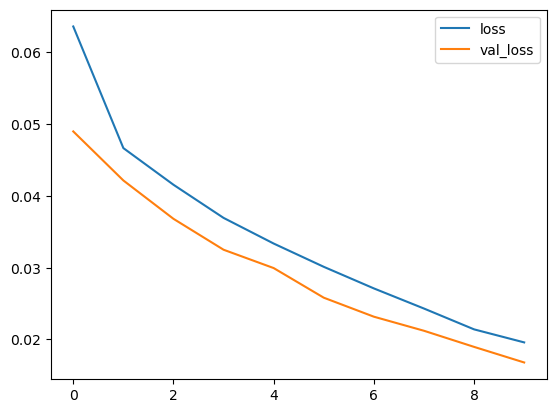

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(Engine.history).plot()
plt.show()

In [19]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.metrics import MeanMetricWrapper


In [20]:
Pre = Precision()
Recal=Recall()
Accuracy=CategoricalAccuracy()

In [21]:
for batch in test.as_numpy_iterator():
    X_true, Y_true = batch
    yhat= model_1.predict(X_true)
    Y_true = Y_true.flatten()
    yhat=yhat.flatten()
    Pre.update_state(Y_true, yhat)
    Recal.update_state(Y_true, yhat)
    Accuracy.update_state(Y_true, yhat)


1/1 [==============================] - 0s 85ms/step


In [22]:
print(f'Precision: {Pre.result().numpy()}, Recall: {Recal.result().numpy()}, Accuracy: {Accuracy.result().numpy()}')

Precision: 0.9196481108665466, Recall: 0.9063583612442017, Accuracy: 0.49548646807670593


In [23]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

# Select a random subset of test data for visualization
num_samples = 100
subset_indices = np.random.choice(len(test), num_samples, replace=False)
subset_indices_scalar = subset_indices[0]  # Extract the first element as a scalar
subset_test = test.take(subset_indices_scalar)

# Initialize lists to store original and predicted values
original_values = []
predicted_values = []

# Iterate over the subset of test data
for batch in subset_test.as_numpy_iterator():
    X_true, Y_true = batch
    yhat = model_1.predict(X_true).flatten()
    
    # Append to the lists
    original_values.extend(Y_true.flatten())
    predicted_values.extend(yhat)

# Create a scatter plot


1/1 [==============================] - 0s 83ms/step


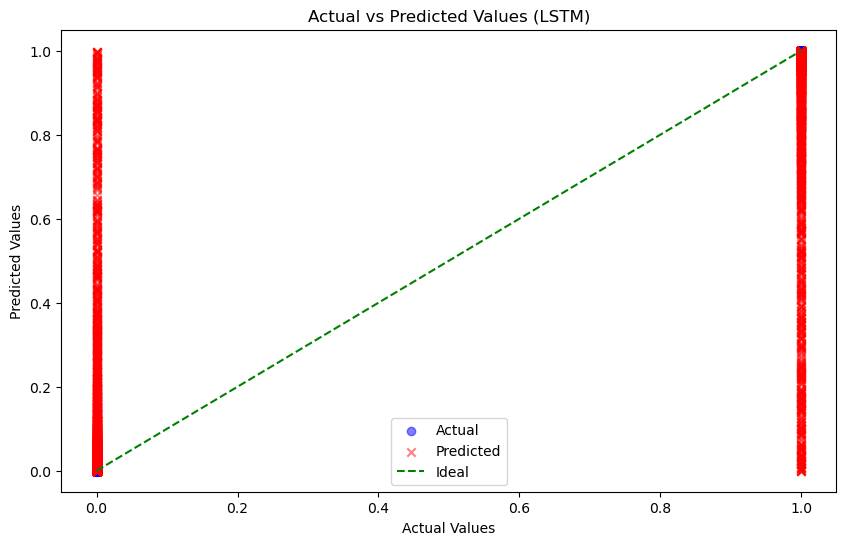

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(original_values, original_values, alpha=0.5, c='blue', marker='o', label='Actual')
plt.scatter(original_values, predicted_values, alpha=0.5, c='red', marker='x', label='Predicted')
plt.plot([min(original_values), max(original_values)], [min(original_values), max(original_values)], linestyle='--', color='green', label='Ideal')
plt.title('Actual vs Predicted Values (LSTM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [25]:
input_text = vector('I will kill all muslims')

In [54]:
model_1.predict(np.array([input_text]))>.5

1/1 [==============================] - 0s 407ms/step


array([[ True, False, False, False, False, False]])

In [27]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
model_2 = Sequential()
model_2.add(Embedding(Max+1, 32))
model_2.add(Conv1D(128, 5, activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(6, activation='sigmoid'))

In [29]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [30]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         20608     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                      

In [31]:
Engine2 = model_2.fit(train, epochs=10, validation_data=val)

Epoch 1/10

6981/6981 [==============================] - 780s 112ms/step - loss: 0.0620 - accuracy: 0.9939 - val_loss: 0.0456 - val_accuracy: 0.9940
Epoch 2/10
6981/6981 [==============================] - 781s 112ms/step - loss: 0.0452 - accuracy: 0.9942 - val_loss: 0.0375 - val_accuracy: 0.9944
Epoch 3/10
6981/6981 [==============================] - 732s 105ms/step - loss: 0.0389 - accuracy: 0.9914 - val_loss: 0.0329 - val_accuracy: 0.9945
Epoch 4/10
6981/6981 [==============================] - 721s 103ms/step - loss: 0.0334 - accuracy: 0.9919 - val_loss: 0.0271 - val_accuracy: 0.9938
Epoch 5/10
6981/6981 [==============================] - 721s 103ms/step - loss: 0.0294 - accuracy: 0.9926 - val_loss: 0.0249 - val_accuracy: 0.9939
Epoch 6/10
6981/6981 [==============================] - 723s 104ms/step - loss: 0.0256 - accuracy: 0.9749 - val_loss: 0.0208 - val_accuracy: 0.9937
Epoch 7/10
6981/6981 [==============================] - 730s 105ms/step - loss: 0.0229 - accuracy: 0.9051 - val

<Figure size 800x500 with 0 Axes>

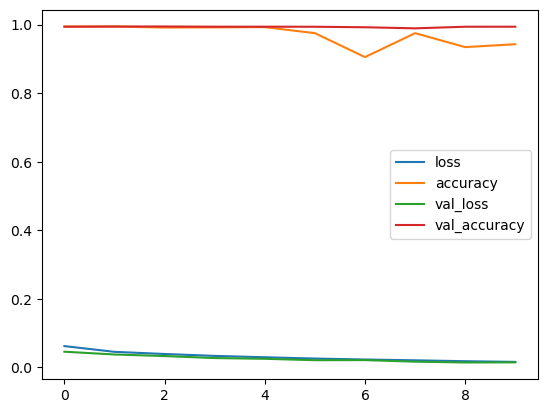

In [32]:
plt.figure(figsize=(8,5))
pd.DataFrame(Engine2.history).plot()
plt.show()

In [33]:
Pre1 = Precision()
Recal1 =Recall()
Accuracy1 =CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X_true, Y_true = batch
    yhat= model_2.predict(X_true)
    Y_true = Y_true.flatten()
    yhat=yhat.flatten()
    Pre1.update_state(Y_true, yhat)
    Recal1.update_state(Y_true, yhat)
    Accuracy1.update_state(Y_true, yhat)


1/1 [==============================] - 0s 28ms/step


In [35]:
print(f'Precision: {Pre1.result().numpy()}, Recall: {Recal1.result().numpy()}, Accuracy: {Accuracy1.result().numpy()}')

Precision: 0.9210177659988403, Recall: 0.9427563548088074, Accuracy: 0.5336008071899414


In [36]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]


In [37]:
# Select a random subset of test data for visualization
num_samples = 100
subset_indices = np.random.choice(len(test), num_samples, replace=False)
subset_indices_scalar = subset_indices[0]  # Extract the first element as a scalar
subset_test = test.take(subset_indices_scalar)

In [38]:
original_values = []
predicted_values = []

In [39]:
for batch in subset_test.as_numpy_iterator():
    X_true, Y_true = batch
    yhat = model_1.predict(X_true).flatten()
    
    # Append to the lists
    original_values.extend(Y_true.flatten())
    predicted_values.extend(yhat)

1/1 [==============================] - 0s 83ms/step


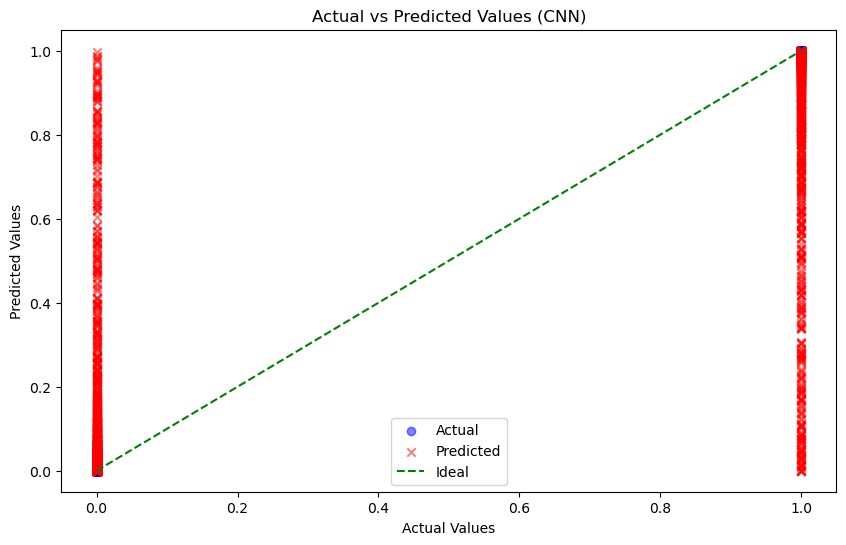

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(original_values, original_values, alpha=0.5, c='blue', marker='o', label='Actual')
plt.scatter(original_values, predicted_values, alpha=0.5, c='red', marker='x', label='Predicted')
plt.plot([min(original_values), max(original_values)], [min(original_values), max(original_values)], linestyle='--', color='green', label='Ideal')
plt.title('Actual vs Predicted Values (CNN)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [41]:
precision_values = [Pre.result().numpy(), Pre1.result().numpy()]
recall_values = [Recal.result().numpy(), Recal1.result().numpy()]
accuracy_values = [Accuracy.result().numpy(), Accuracy1.result().numpy()]

In [42]:
labels = ['LSTM', 'CNN']
x = np.arange(len(labels))

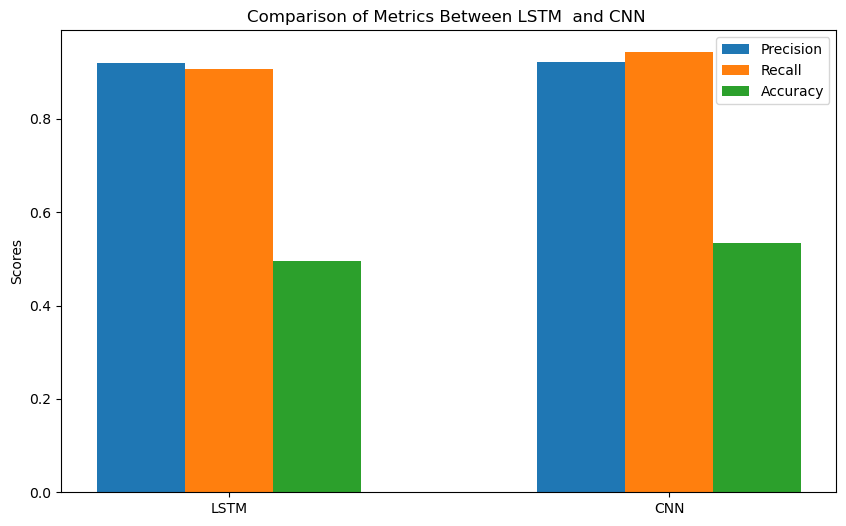

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
bar1 = ax.bar(x - bar_width, precision_values, width=bar_width, label='Precision')
bar2 = ax.bar(x, recall_values, width=bar_width, label='Recall')
bar3 = ax.bar(x + bar_width, accuracy_values, width=bar_width, label='Accuracy')

# Adding labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Between LSTM  and CNN ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [44]:
model_1.save("LSTM")
model_2.save("CNN")

INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


In [45]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
model_1 = load_model("LSTM")
model_2 = load_model("CNN")

# Function to get predictions from a model
def get_predictions(model, dataset):
    predictions = []
    ground_truth = []

    for batch in dataset.as_numpy_iterator():
        X_true, Y_true = batch
        yhat = model.predict(X_true)
        predictions.extend(yhat)
        ground_truth.extend(Y_true)

    return np.array(predictions), np.array(ground_truth)

# Get predictions for model_1
predictions_model_1, ground_truth_model_1 = get_predictions(model_1, test)

# Get predictions for model_2
predictions_model_2, ground_truth_model_2 = get_predictions(model_2, test)

# Threshold for binary classification (adjust as needed)
threshold = 0.5

# Convert predictions to binary (0 or 1) based on the threshold
binary_predictions_model_1 = (predictions_model_1 > threshold).astype(int)
binary_predictions_model_2 = (predictions_model_2 > threshold).astype(int)

# Evaluate model_1
accuracy_model_1 = accuracy_score(ground_truth_model_1, binary_predictions_model_1)
classification_report_model_1 = classification_report(ground_truth_model_1, binary_predictions_model_1)

print("LSTM - Test Accuracy:", accuracy_model_1)
print("LSTM - Classification Report:\n", classification_report_model_1)

# Evaluate model_2
accuracy_model_2 = accuracy_score(ground_truth_model_2, binary_predictions_model_2)
classification_report_model_2 = classification_report(ground_truth_model_2, binary_predictions_model_2)

print("CNN - Test Accuracy:", accuracy_model_2)
print("CNN - Classification Report:\n", classification_report_model_2)

1/1 [==============================] - 0s 22ms/step
LSTM - Test Accuracy: 0.9694709127382146
LSTM - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1507
           1       0.63      0.85      0.73       157
           2       0.93      0.95      0.94       830
           3       0.00      0.00      0.00        47
           4       0.91      0.86      0.89       782
           5       0.87      0.80      0.83       151

   micro avg       0.91      0.90      0.91      3474
   macro avg       0.72      0.74      0.72      3474
weighted avg       0.91      0.90      0.90      3474
 samples avg       0.09      0.09      0.09      3474

CNN - Test Accuracy: 0.9742978936810431
CNN - Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1502
           1       0.73      0.78      0.76       156
           2       0.93      0.95      0.94   

C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_cla